# NLP Project, Classification of Amazon Reviews and Key Phrases
#### CSCI 3832 Natural Language Processing
Members: Adam Wuth, Benjamin Kohav, Noah Vilas, Aiden Devine, Evan Zachary

### Requirements

In [2]:
import os, random, sys, copy
import torch, torch.nn as nn, numpy as np
from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from datasets import load_dataset, concatenate_datasets, load_from_disk
from datetime import datetime
import matplotlib.pyplot as plt

#seperate imports for bert
from datasets import concatenate_datasets, DatasetDict, Dataset
from sklearn.model_selection import train_test_split
from datasets import load_from_disk
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



### Load in the data set
The dataset is split into categories, but we wanted all categories from 2023. This code block will take forever to run, only run it the first time to get the dataset. In order to do that, I loaded in 1000000, and filter from there
# **Only run this code block if you have not used the make_dataset.ipynb**

In [2]:
#The dataset is split into categories

categories = [
    "All_Beauty",
    "Amazon_Fashion",
    "Appliances",
    "Arts_Crafts_and_Sewing",
    "Automotive",
    "Baby_Products",
    "Beauty_and_Personal_Care",
    "Books",
    "CDs_and_Vinyl",
    "Cell_Phones_and_Accessories",
    "Clothing_Shoes_and_Jewelry",
    "Digital_Music",
    "Electronics",
    "Gift_Cards",
    "Grocery_and_Gourmet_Food",
    "Handmade_Products",
    "Health_and_Household",
    "Health_and_Personal_Care",
    "Home_and_Kitchen",
    "Industrial_and_Scientific",
    "Kindle_Store",
    "Magazine_Subscriptions",
    "Movies_and_TV",
    "Musical_Instruments",
    "Office_Products",
    "Patio_Lawn_and_Garden",
    "Pet_Supplies",
    "Software",
    "Sports_and_Outdoors",
    "Subscription_Boxes",
    "Tools_and_Home_Improvement",
    "Toys_and_Games",
    "Video_Games",
    "Unknown"
]


limit = 589  # 100,000 target reviews 34 categories 5 stars, (100,000/34)/5 = 889

allcats = []

for cat in categories:
    print(f"Loading category: {cat}")
    #arbitrary 10000000 to make sure I get enough data after filter
    dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_review_{cat}", split="full[:1000000]", trust_remote_code=True)
    #dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_review_{cat}", split="full[:1%]",  trust_remote_code=True)
    #to get reviews from 2023 onwards 2020 onwards was millions of reviews and was taking
    #over an hour just to load the data
    filtered_dataset = dataset.filter(lambda x: x['timestamp'] >= int(datetime(2023, 1, 1).timestamp() * 1000))
    #in each category, for stars 1-5(not inclusive)
    for star in range(1, 6):
        data = dataset.filter(lambda x: int(float(x["rating"])) == star)
        if len(data) >= limit:
            #trim extra reviews randomly to avoid bias
            data = data.shuffle().select(range(limit))
            allcats.append(data)


Loading category: All_Beauty
Loading category: Amazon_Fashion
Loading category: Appliances
Loading category: Arts_Crafts_and_Sewing
Loading category: Automotive
Loading category: Baby_Products
Loading category: Beauty_and_Personal_Care
Loading category: Books
Loading category: CDs_and_Vinyl
Loading category: Cell_Phones_and_Accessories
Loading category: Clothing_Shoes_and_Jewelry
Loading category: Digital_Music
Loading category: Electronics
Loading category: Gift_Cards
Loading category: Grocery_and_Gourmet_Food
Loading category: Handmade_Products
Loading category: Health_and_Household
Loading category: Health_and_Personal_Care
Loading category: Home_and_Kitchen
Loading category: Industrial_and_Scientific
Loading category: Kindle_Store
Loading category: Magazine_Subscriptions
Loading category: Movies_and_TV
Loading category: Musical_Instruments


Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Loading category: Office_Products


Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Loading category: Patio_Lawn_and_Garden


Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Loading category: Pet_Supplies


Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Loading category: Software


Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Loading category: Sports_and_Outdoors


Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Loading category: Subscription_Boxes


Filter:   0%|          | 0/16216 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16216 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16216 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16216 [00:00<?, ? examples/s]

Filter:   0%|          | 0/16216 [00:00<?, ? examples/s]

Loading category: Tools_and_Home_Improvement


Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Loading category: Toys_and_Games


Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Loading category: Video_Games


Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Loading category: Unknown


Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

In [ ]:
#Save reviews so we don't have to run code again
reviews = concatenate_datasets(allcats)
reviews.save_to_disk("filetred_amazon_reviews")
print(Counter(reviews["rating"])) 
print(f"Total reviews loaded: {len(reviews)}")

If you have run that already, reviews was saved(should be in the working directory)so you can just do the next code block instead
## If you have your dataset already, start here

In [3]:
reviews = load_from_disk("filetred_amazon_reviews")

In [4]:
#code to make sure reviews is working
print(len(reviews))
print(reviews[0])
print(reviews[1])
print(reviews.column_names)

100130
{'rating': 1.0, 'title': 'Worst nail polish ever', 'text': 'Worst nail polish ever! My daughter and I both used this nail polish in two different colors and now our nails are damaged. Our nails split horizontally and are peeling. Plus the damage has caused pain. Worst Sally Hansen product ever!', 'images': [], 'asin': 'B011855ADM', 'parent_asin': 'B011855ADM', 'user_id': 'AEMVAG56MA7MAFULCQJEOVJCKGHA', 'timestamp': 1454738837000, 'helpful_vote': 8, 'verified_purchase': True}
{'rating': 1.0, 'title': 'No funciona para mi', 'text': 'Bueno en cuanto a mi respondo que no me funciono. Tengo pocas pestañas, las enchufe antes de poner la máscara y el resultado desastroso. El producto hizo que mis pestañas perdieran el volumen del encrespado horrible.', 'images': [], 'asin': 'B09GTV6WL6', 'parent_asin': 'B09GTV6WL6', 'user_id': 'AFPNHXMEBYKO3SPMFXZCALLZ5IHA', 'timestamp': 1645820993736, 'helpful_vote': 5, 'verified_purchase': True}
['rating', 'title', 'text', 'images', 'asin', 'parent_a

## Documentation used for DistilBERT code
These are the resources I used in making this notebook. If you get stuck or are trying to make it yourself, these are good resources
1. for classification:
https://medium.com/@prakashram1327/building-a-text-classification-model-using-distilbert-703c1409696c
2. for model and tokenization:https://huggingface.co/distilbert/distilbert-base-uncased
3. for training and tesing: https://ai.plainenglish.io/training-a-distilbert-model-from-scratch-9fc627bd4f17
4. Other resources:
https://discuss.huggingface.co/t/how-is-the-data-shifted-by-one-token-during-causallm-fine-tuning/36386/3
https://discuss.huggingface.co/t/getting-40-accuracy-need-suggestions-to-improve/63456
https://github.com/huggingface/transformers/issues/17256
https://huggingface.co/google-bert/bert-base-uncased
https://discuss.huggingface.co/t/how-is-the-data-shifted-by-one-token-during-causallm-fine-tuning/36386

## Tokenizing and using less data because of crashing issues
I tried training with larger data, but it kept crashing the curc kernel. To combat this, I made this code bellow to filter out 5000 reviews, still evenly split.

In [5]:
#0-4 instead of 1-5
def preprocess(example):
    example['labels'] = int(example['rating']) - 1
    return example
#tokenize helper
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

In [16]:
samples_per_class = 1000
rate = []
#to get even split still
for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    data = reviews.filter(lambda x: x["rating"] == rating)
    data = data.shuffle().select(range(min(len(data), samples_per_class)))
    rate.append(data)
#back into one set
reviews_small = concatenate_datasets(rate).shuffle()


#Finish toekenizing and check results
reviews_small = reviews_small.map(preprocess)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenized = reviews_small.map(tokenize_function, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
print(Counter(reviews_small["rating"])) 


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Counter({1.0: 1000, 2.0: 1000, 5.0: 1000, 4.0: 1000, 3.0: 1000})


## Training split

In [19]:
ratings = [0, 1, 2, 3, 4]
train_splits = []
valid_splits = []
#in order to split data, but still get equal split
for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    data = tokenized.filter(lambda x: x["rating"] == rating)
    #using pandas for sklearn split
    df = data.to_pandas()
    train_df, val_df = train_test_split(df, test_size=0.2)
    train_splits.append(Dataset.from_pandas(train_df))
    valid_splits.append(Dataset.from_pandas(val_df))

# take ratings and add back together into training and test
train_dataset = concatenate_datasets(train_splits).shuffle()
test_dataset = concatenate_datasets(valid_splits).shuffle()
print(Counter(train_dataset["rating"])) 
print(Counter(test_dataset["rating"])) 

Counter({2.0: 800, 3.0: 800, 4.0: 800, 1.0: 800, 5.0: 800})
Counter({5.0: 200, 1.0: 200, 4.0: 200, 2.0: 200, 3.0: 200})


In [20]:
device = torch.device("cpu")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=5)
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [21]:

optim = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 3
test_loader = valid_loader
#for grpah
training_losses =[]
accuracies =[]


for epoch in range(epochs):
    print(f"\n--- Epoch {epoch + 1} ---")
    
    model.train()
    train_losses = []
    loop = tqdm(train_loader, leave=True)
    
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

        train_losses.append(loss.item())
        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(train_loss=loss.item())
    training_losses.append(np.mean(train_losses))
    print("Mean Training Loss:", np.mean(train_losses))

    # Evaluation
    model.eval()
    test_losses = []
    all_preds = []
    all_labels = []

    loop = tqdm(test_loader, leave=True)
    with torch.no_grad():
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            test_losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loop.set_description(f'Val Epoch {epoch + 1}')
            loop.set_postfix(val_loss=loss.item())

    accuracy = accuracy_score(all_labels, all_preds)
    accuracies.append(accuracy * 100)
    print("Mean Test Loss:", np.mean(test_losses))
    print(f"Validation Accuracy: {accuracy * 100:.4f}")



--- Epoch 1 ---


Epoch 1: 100%|██████████| 500/500 [27:59<00:00,  3.36s/it, train_loss=1.44] 


Mean Training Loss: 1.288275830745697


Val Epoch 1: 100%|██████████| 125/125 [02:08<00:00,  1.03s/it, val_loss=1.17] 


Mean Test Loss: 1.1857834038734436
Validation Accuracy: 45.3000

--- Epoch 2 ---


Epoch 2: 100%|██████████| 500/500 [28:01<00:00,  3.36s/it, train_loss=0.792]


Mean Training Loss: 1.0268368200659752


Val Epoch 2: 100%|██████████| 125/125 [02:08<00:00,  1.03s/it, val_loss=1.28] 


Mean Test Loss: 1.1773173222541808
Validation Accuracy: 48.5000

--- Epoch 3 ---


Epoch 3: 100%|██████████| 500/500 [27:52<00:00,  3.35s/it, train_loss=1.19] 


Mean Training Loss: 0.7873878847658634


Val Epoch 3: 100%|██████████| 125/125 [02:08<00:00,  1.03s/it, val_loss=1.43] 

Mean Test Loss: 1.318415300130844
Validation Accuracy: 46.4000


In [22]:
model.save_pretrained("small_DistillBERT/")
tokenizer.save_pretrained("small_DistillBERT/")

('small_DistillBERT/tokenizer_config.json',
 'small_DistillBERT/special_tokens_map.json',
 'small_DistillBERT/vocab.txt',
 'small_DistillBERT/added_tokens.json')

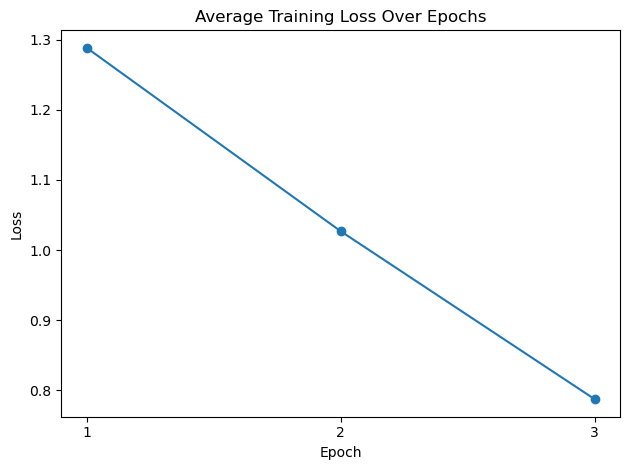

In [40]:
plt.plot(range(1, len(training_losses) + 1), training_losses, marker='o')
plt.title("Average Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, len(training_losses) + 1))
plt.tight_layout()
plt.show()


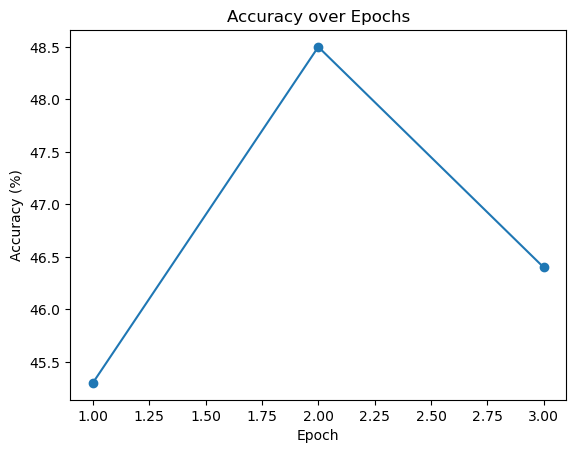

In [41]:
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.show()


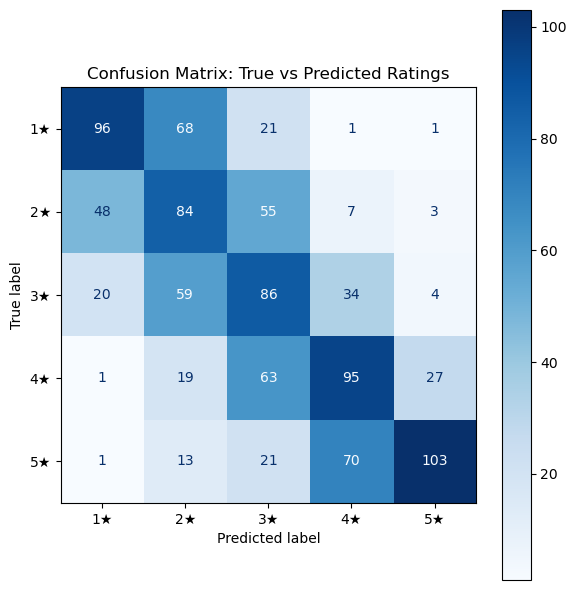

In [ ]:
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3, 4])  # 0 to 4 == 1 to 5 stars
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1★", "2★", "3★", "4★", "5★"])

# #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix: True vs Predicted Ratings")
plt.tight_layout()
plt.show()

## Testing DistilBERT with a larger dataset

In [6]:
samples_per_class = 2000
rate = []
#to get even split still
for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    data = reviews.filter(lambda x: x["rating"] == rating)
    data = data.shuffle().select(range(min(len(data), samples_per_class)))
    rate.append(data)
#back into one set
reviews_larger = concatenate_datasets(rate).shuffle()


#Finish toekenizing and check results
reviews_larger = reviews_larger.map(preprocess)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenized = reviews_larger.map(tokenize_function, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
print(Counter(reviews_larger["rating"])) 


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Counter({3.0: 2000, 4.0: 2000, 5.0: 2000, 2.0: 2000, 1.0: 2000})


In [7]:
ratings = [0, 1, 2, 3, 4]
train_splits = []
valid_splits = []
#in order to split data, but still get equal split
for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    data = tokenized.filter(lambda x: x["rating"] == rating)
    #using pandas for sklearn split
    df = data.to_pandas()
    train_df, val_df = train_test_split(df, test_size=0.2)
    train_splits.append(Dataset.from_pandas(train_df))
    valid_splits.append(Dataset.from_pandas(val_df))

# take ratings and add back together into training and test
# Re-tokenize and set format after splitting
train_dataset = concatenate_datasets(train_splits).map(tokenize_function, batched=True)
test_dataset = concatenate_datasets(valid_splits).map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print(Counter(train_dataset["rating"])) 
print(Counter(test_dataset["rating"])) 
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=8)

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Counter({1.0: 1600, 2.0: 1600, 3.0: 1600, 4.0: 1600, 5.0: 1600})
Counter({1.0: 400, 2.0: 400, 3.0: 400, 4.0: 400, 5.0: 400})


In [8]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=8)

device = torch.device("cpu")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=5)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [9]:

optim = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 3
test_loader = valid_loader
#for grpah
training_losses =[]
accuracies =[]


for epoch in range(epochs):
    print(f"\n--- Epoch {epoch + 1} ---")
    
    model.train()
    train_losses = []
    loop = tqdm(train_loader, leave=True)
    
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

        train_losses.append(loss.item())
        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(train_loss=loss.item())
    training_losses.append(np.mean(train_losses))
    print("Mean Training Loss:", np.mean(train_losses))

    # Evaluation
    model.eval()
    test_losses = []
    all_preds = []
    all_labels = []

    loop = tqdm(test_loader, leave=True)
    with torch.no_grad():
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            test_losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loop.set_description(f'Val Epoch {epoch + 1}')
            loop.set_postfix(val_loss=loss.item())

    accuracy = accuracy_score(all_labels, all_preds)
    accuracies.append(accuracy * 100)
    print("Mean Test Loss:", np.mean(test_losses))
    print(f"Validation Accuracy: {accuracy * 100:.4f}")


--- Epoch 1 ---


Epoch 1: 100%|██████████| 1000/1000 [55:42<00:00,  3.34s/it, train_loss=1.17]


Mean Training Loss: 1.253199111700058


Val Epoch 1: 100%|██████████| 250/250 [04:16<00:00,  1.03s/it, val_loss=0.476]


Mean Test Loss: 1.145000300168991
Validation Accuracy: 49.1000

--- Epoch 2 ---


Epoch 2: 100%|██████████| 1000/1000 [55:33<00:00,  3.33s/it, train_loss=1.26]


Mean Training Loss: 1.0226226825416087


Val Epoch 2: 100%|██████████| 250/250 [04:16<00:00,  1.03s/it, val_loss=0.398]


Mean Test Loss: 1.1695368404388429
Validation Accuracy: 47.4500

--- Epoch 3 ---


Epoch 3: 100%|██████████| 1000/1000 [55:29<00:00,  3.33s/it, train_loss=0.803]


Mean Training Loss: 0.8145481698513031


Val Epoch 3: 100%|██████████| 250/250 [04:16<00:00,  1.03s/it, val_loss=0.497]

Mean Test Loss: 1.2454515389800072
Validation Accuracy: 49.5000


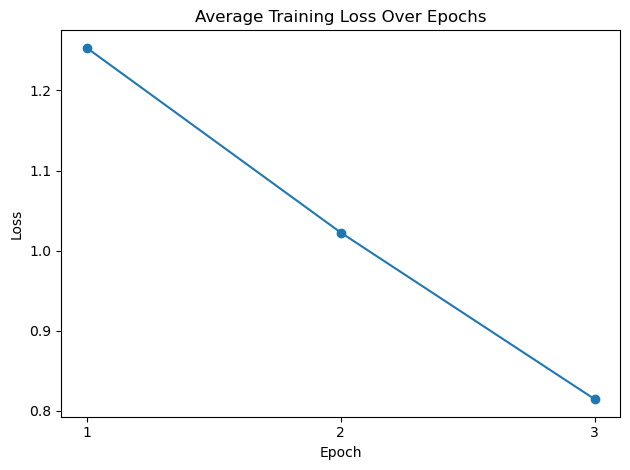

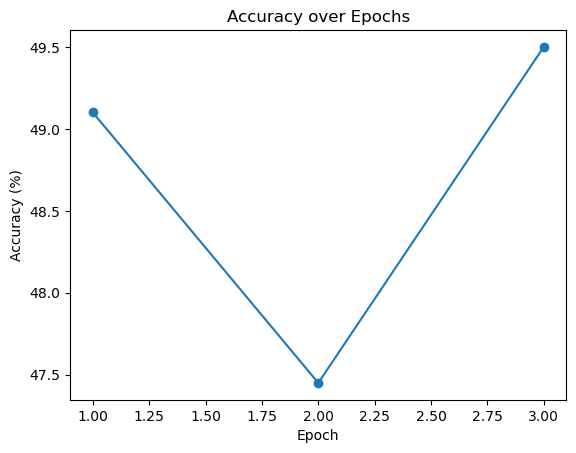

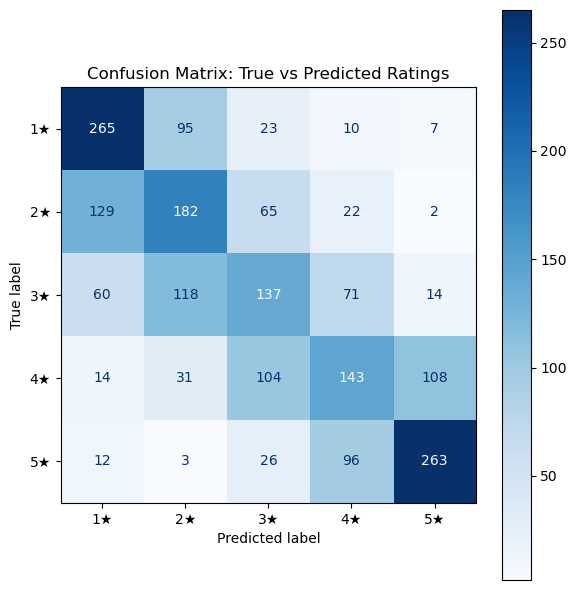

In [13]:
model.save_pretrained("large_DistillBERT/")
tokenizer.save_pretrained("large_DistillBERT/")

plt.plot(range(1, len(training_losses) + 1), training_losses, marker='o')
plt.title("Average Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, len(training_losses) + 1))
plt.tight_layout()
plt.show()

plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.show()
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3, 4])  # 0 to 4 == 1 to 5 stars
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1★", "2★", "3★", "4★", "5★"])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix: True vs Predicted Ratings")
plt.tight_layout()
plt.show()

## Full Data
Ideally, we would be able to train a model with the full dataset as would be done here, but due to time and computing constraints, I was unable to complete this trainging in time. I tried to run it over night twice, but it failed both times. After fixing the dataset, I was unable to train with more examples